<h3><b>Importing Required Dependencies</b></h3>

In [32]:
import json
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle #for saving history object
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.xception import preprocess_input  # Adjusted import for Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from datetime import datetime



<h3><b>Data Preprocessing</b></h3>

In [33]:
# Define directories and hyperparameters
train_dir = 'E:/S8 LAB/New Plant Dataset/New Plant Dataset/train'
val_dir = 'E:/S8 LAB/New Plant Dataset/New Plant Dataset/valid'
test_dir = 'E:/S8 LAB/New Plant Dataset/test/test'

(256, 256, 3)


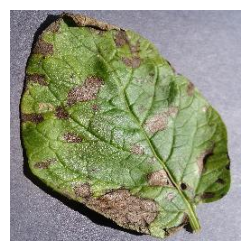

In [34]:
image_path = r'E:\S8 LAB\New Plant Dataset\New Plant Dataset\valid\Potato___Early_blight\0a6983a5-895e-4e68-9edb-88adf79211e9___RS_Early.B 9072.JPG'

# Read the image
img = plt.imread(image_path)

print(img.shape)
plt.figure(figsize=(3,3))
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [35]:
image_path = r'E:\S8 LAB\New Plant Dataset\New Plant Dataset\valid\Potato___Early_blight\0a6983a5-895e-4e68-9edb-88adf79211e9___RS_Early.B 9072.JPG'

# Read the image
img = plt.imread(image_path)

print(img)

[[[108 106 120]
  [ 83  81  95]
  [116 114 128]
  ...
  [153 156 175]
  [153 156 175]
  [153 156 175]]

 [[110 108 122]
  [122 120 134]
  [ 80  78  92]
  ...
  [154 157 176]
  [154 157 176]
  [155 158 177]]

 [[144 142 156]
  [128 126 140]
  [ 93  91 105]
  ...
  [157 160 179]
  [157 160 179]
  [158 161 180]]

 ...

 [[129 127 141]
  [142 140 154]
  [128 126 140]
  ...
  [188 187 201]
  [190 189 203]
  [186 185 199]]

 [[112 110 124]
  [125 123 137]
  [128 126 140]
  ...
  [180 179 193]
  [187 186 200]
  [189 188 202]]

 [[111 109 123]
  [115 113 127]
  [117 115 129]
  ...
  [187 186 200]
  [195 194 208]
  [201 200 214]]]


In [36]:
#Image and train parameters
img_size = (224, 224)
batch_size = 16
epochs = 15
patience = 5

<h3><b>Splitting of Data for Train, Validation & Test</b></h3>

In [37]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,

    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 338 images belonging to 17 classes.


<h3><b>Building the DenseNet Model</b></h3>

In [39]:
# Build the model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [40]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
# Define callbacks
checkpoint = ModelCheckpoint('plant_disease_detection_densenet.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

<h3><b>Model Training</b></h3>

In [42]:
# Get the base model name
base_model_name = base_model.name

# Get the current date and time
current_date = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

# Define the file name using the model name and current date
file_name = f"models/{base_model_name}_plant_disease_detection[{current_date}].h5"

# Check if the file already exists
if os.path.exists(file_name):
    # Prompt the user to enter a new name
    print(file_name," already exits!!")
    new_name = input("A file with the same name already exists. Please enter a new name: ")
    file_name = f"models/{new_name}.h5"
print("New file name : ",file_name)

# Define callbacks
checkpoint = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

New file name :  models/densenet201_plant_disease_detection[08-04-2024_10-04-26].h5


In [43]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/15
796/796 [==============================] - ETA: 0s - loss: 2.4032 - accuracy: 0.3151
Epoch 1: val_accuracy improved from -inf to 0.58120, saving model to models\densenet201_plant_disease_detection[08-04-2024_10-04-26].h5


C:\Users\ASUS LAPTOP\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


796/796 [==============================] - 1486s 2s/step - loss: 2.4032 - accuracy: 0.3151 - val_loss: 1.0772 - val_accuracy: 0.5812
Epoch 2/15
796/796 [==============================] - ETA: 0s - loss: 1.7361 - accuracy: 0.3665
Epoch 2: val_accuracy improved from 0.58120 to 0.66009, saving model to models\densenet201_plant_disease_detection[08-04-2024_10-04-26].h5
796/796 [==============================] - 1407s 2s/step - loss: 1.7361 - accuracy: 0.3665 - val_loss: 0.9049 - val_accuracy: 0.6601
Epoch 3/15
796/796 [==============================] - ETA: 0s - loss: 1.6352 - accuracy: 0.3889
Epoch 3: val_accuracy improved from 0.66009 to 0.79841, saving model to models\densenet201_plant_disease_detection[08-04-2024_10-04-26].h5
796/796 [==============================] - 1393s 2s/step - loss: 1.6352 - accuracy: 0.3889 - val_loss: 0.7041 - val_accuracy: 0.7984
Epoch 4/15
796/796 [==============================] - ETA: 0s - loss: 1.6163 - accuracy: 0.4113
Epoch 4: val_accuracy did not impro

In [45]:
# Load model
model = load_model('models/densenet201_plant_disease_detection[08-04-2024_10-04-26].h5')

In [46]:
# Save history object
with open('history[densenet20108042024].pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [47]:

# Load history object
with open('history[densenet20108042024].pkl', 'rb') as f:
    loaded_history = pickle.load(f)


<h3><b>Evaluation of Model</b></h3>

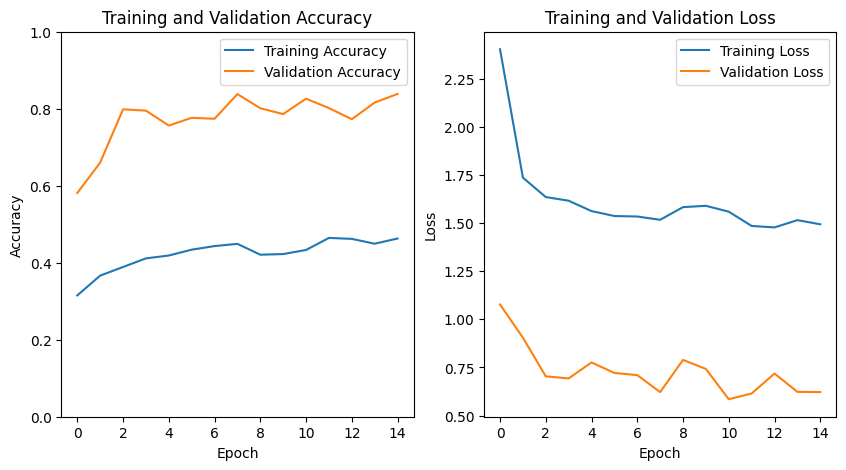

In [48]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

22/22 [==============================] - 35s 1s/step
There were 209 errors in 338 tests for an accuracy of 38.17


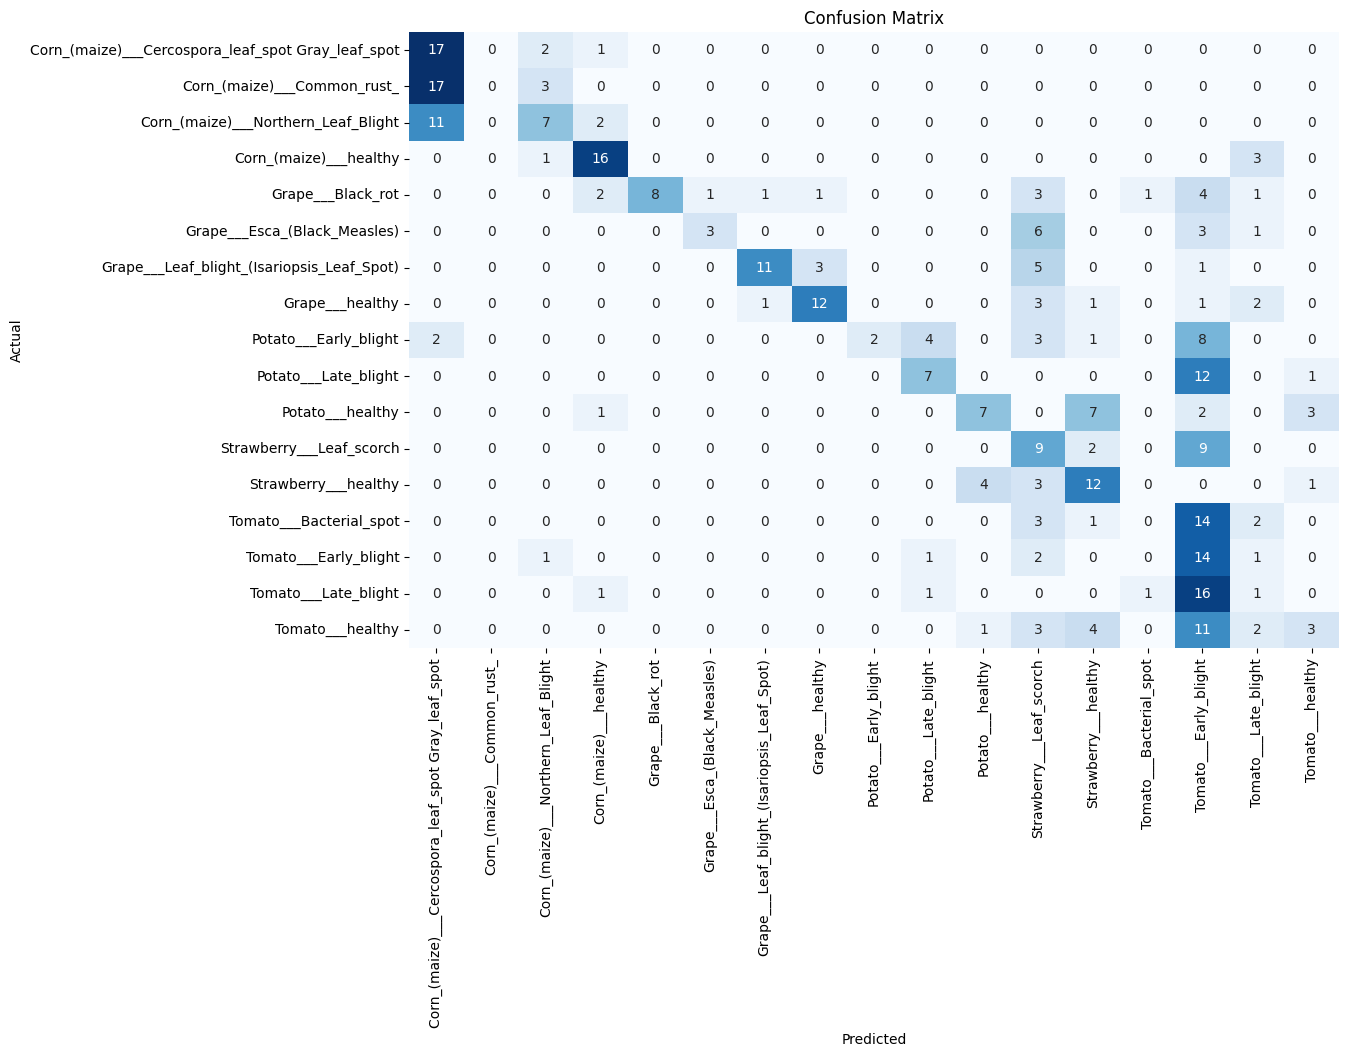

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.3617    0.8500    0.5075        20
                       Corn_(maize)___Common_rust_     0.0000    0.0000    0.0000        20
               Corn_(maize)___Northern_Leaf_Blight     0.5000    0.3500    0.4118        20
                            Corn_(maize)___healthy     0.6957    0.8000    0.7442        20
                                 Grape___Black_rot     1.0000    0.3636    0.5333        22
                      Grape___Esca_(Black_Measles)     0.7500    0.2308    0.3529        13
        Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.8462    0.5500    0.6667        20
                                   Grape___healthy     0.7500    0.6000    0.6667        20
                             Potato___Early_blight     1.0000    0.1000    0.1818        20
                              Po

C:\Users\ASUS LAPTOP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS LAPTOP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS LAPTOP\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [49]:
def predictor(test_gen):    
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)    
    for i, p in enumerate(preds):        
        pred_index = np.argmax(p)         
        true_index = test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors = errors + 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc = (1 - errors/tests) * 100
    msg = f'There were {errors} errors in {tests} tests for an accuracy of {acc:.2f}'
    print(msg)
    
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_generator)

In [50]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('/nTest accuracy:', test_acc)
print('Test Loss:', test_loss)

22/22 - 26s - loss: 2.4136 - accuracy: 0.3817 - 26s/epoch - 1s/step
/nTest accuracy: 0.38165679574012756
Test Loss: 2.4136404991149902


In [57]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Save class indices to a JSON file
with open('class_indices_densenet.json', 'w') as f:
    json.dump(class_indices, f)

<h3><b>Prediction of Disease</b></h3>

In [58]:
# Function to predict disease from an image
def predict_disease(image_path):

    img = load_img(image_path, target_size=(img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)[0]
    predicted_class_index = np.argmax(prediction)
    disease = class_indices[str(predicted_class_index)]
    confidence = prediction[predicted_class_index]

    return disease, confidence 

In [59]:
# Load class indices
with open('class_indices_xception.json', 'r') as f:
    class_indices = json.load(f)
class_indices   

{'0': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 '1': 'Corn_(maize)___Common_rust_',
 '2': 'Corn_(maize)___Northern_Leaf_Blight',
 '3': 'Corn_(maize)___healthy',
 '4': 'Grape___Black_rot',
 '5': 'Grape___Esca_(Black_Measles)',
 '6': 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 '7': 'Grape___healthy',
 '8': 'Potato___Early_blight',
 '9': 'Potato___Late_blight',
 '10': 'Potato___healthy',
 '11': 'Strawberry___Leaf_scorch',
 '12': 'Strawberry___healthy',
 '13': 'Tomato___Bacterial_spot',
 '14': 'Tomato___Early_blight',
 '15': 'Tomato___Late_blight',
 '16': 'Tomato___healthy'}

In [56]:
# Load remedies
with open('remedies.json', 'r') as f:
    remedies= json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'remedies.json'

In [60]:
image_path = r'E:\S8 LAB\New Plant Dataset\New Plant Dataset\valid\Potato___Early_blight\0a6983a5-895e-4e68-9edb-88adf79211e9___RS_Early.B 9072.JPG' 

disease, confidence = predict_disease(image_path)

print(f'Predicted Disease: {disease}, Confidence: {confidence}')

if disease.strip() in remedies:
    remedy = remedies[disease]
    print(f'Remedies: {remedy}')
else:
    print('No remedies found for this disease.')


1/1 [==============================] - 8s 8s/step
Predicted Disease: Potato___Early_blight, Confidence: 0.9941889047622681


NameError: name 'remedies' is not defined